In [29]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
#import keras_cv
import tensorflow as tf
from tensorflow.python.ops import image_ops  # import ops from tensorflow instead of tensorflow.keras

# Now you can use ops from tensorflow

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 128
EPOCHS = 10
CROP_TO = 32
SEED = 26

PROJECT_DIM = 2048
LATENT_DIM = 512
WEIGHT_DECAY = 0.0005

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
print(f"Total training examples: {len(x_train)}")
print(f"Total test examples: {len(x_test)}")

Total training examples: 50000
Total test examples: 10000


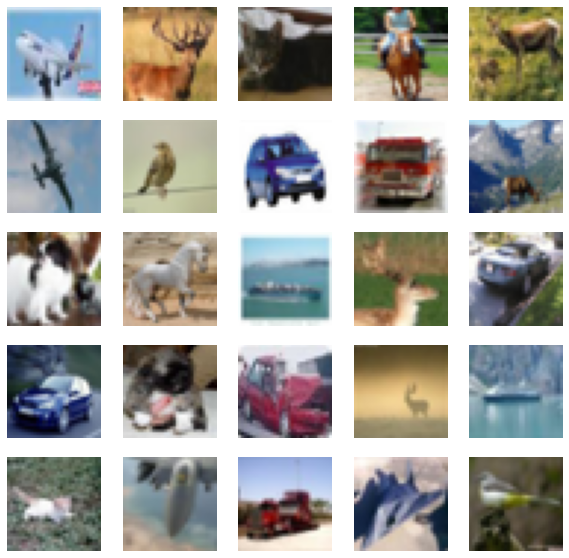

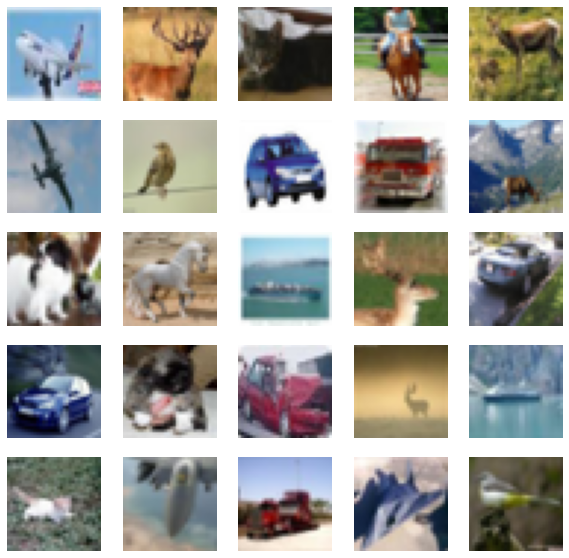

In [25]:
import tensorflow as tf
from tensorflow.keras import layers


strength = [0.4, 0.4, 0.4, 0.1]

random_flip = layers.RandomFlip(mode="horizontal_and_vertical")
random_crop = layers.RandomCrop(CROP_TO, CROP_TO)
random_contrast = layers.RandomContrast((1 - 0.8 * strength[1], 1 + 0.8 * strength[1]))


def flip_random_crop(image):
    # With random crops we also apply horizontal flipping.
    image = random_flip(image)
    image = random_crop(image)
    return image


def color_jitter(x, strength=[0.4, 0.4, 0.3, 0.1]):
    x = random_contrast(x)
    # Affine transformations can disturb the natural range of
    return x


def color_drop(x):
    return x


def random_apply(func, x, p):
        return x


def custom_augment(image):
    # As discussed in the SimCLR paper, the series of augmentation
    # transformations (except for random crops) need to be applied
    # randomly to impose translational invariance.
    image = flip_random_crop(image)
    image = random_apply(color_jitter, image, p=0.8)
    image = random_apply(color_drop, image, p=0.2)
    return image

ssl_ds_one = tf.data.Dataset.from_tensor_slices(x_train)
ssl_ds_one = (
    ssl_ds_one.shuffle(1024, seed=SEED)
    .map(custom_augment, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

ssl_ds_two = tf.data.Dataset.from_tensor_slices(x_train)
ssl_ds_two = (
    ssl_ds_two.shuffle(1024, seed=SEED)
    .map(custom_augment, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# We then zip both of these datasets.
ssl_ds = tf.data.Dataset.zip((ssl_ds_one, ssl_ds_two))

# Visualize a few augmented images.
sample_images_one = next(iter(ssl_ds_one))
plt.figure(figsize=(10, 10))
for n in range(25):
    ax = plt.subplot(5, 5, n + 1)
    plt.imshow(sample_images_one[n].numpy().astype("int"))
    plt.axis("off")
plt.show()

# Ensure that the different versions of the dataset actually contain
# identical images.
sample_images_two = next(iter(ssl_ds_two))
plt.figure(figsize=(10, 10))
for n in range(25):
    ax = plt.subplot(5, 5, n + 1)
    plt.imshow(sample_images_two[n].numpy().astype("int"))
    plt.axis("off")
plt.show()


In [42]:
import resnet_cifar10_v2

N = 2
DEPTH = N * 9 + 2
NUM_BLOCKS = ((DEPTH - 2) // 9) - 1


def get_encoder():
    # Input and backbone.
    inputs = layers.Input((CROP_TO, CROP_TO, 3))
    x = layers.Rescaling(scale=1.0 / 127.5, offset=-1)(
        inputs
    )
    x = resnet_cifar10_v2.stem(x)
    x = resnet_cifar10_v2.learner(x, NUM_BLOCKS)
    x = layers.GlobalAveragePooling2D(name="backbone_pool")(x)

    # Projection head.
    x = layers.Dense(PROJECT_DIM, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dense( PROJECT_DIM, use_bias=False )(x)
    outputs = layers.BatchNormalization()(x)
    return keras.Model(inputs, outputs, name="encoder")


def get_predictor():
    model = keras.Sequential(
        [
            # Note the AutoEncoder-like structure.
            layers.Input((PROJECT_DIM,)),
            layers.Dense(
                LATENT_DIM,
                use_bias=False
            ),
            layers.ReLU(),
            layers.BatchNormalization(),
            layers.Dense(PROJECT_DIM),
        ],
        name="predictor",
    )
    return model

def compute_loss(p, z):
    # The authors of SimSiam emphasize the impact of
    # the `stop_gradient` operator in the paper as it
    # has an important role in the overall optimization.
    z = (z)
    p = tf.math.l2_normalize(p, axis=1)
    z = tf.math.l2_normalize(z, axis=1)
    # Negative cosine similarity (minimizing this is
    # equivalent to maximizing the similarity).
    return -tf.reduce_mean(tf.reduce_sum(p * z, axis=1))

class SimSiam(keras.Model):
    def __init__(self, encoder, predictor):
        super().__init__()
        self.encoder = encoder
        self.predictor = predictor
        self.loss_tracker = keras.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.loss_tracker]

    def train_step(self, data):
        # Unpack the data.
        ds_one, ds_two = data

        # Forward pass through the encoder and predictor.
        with tf.GradientTape() as tape:
            z1, z2 = self.encoder(ds_one), self.encoder(ds_two)
            p1, p2 = self.predictor(z1), self.predictor(z2)
            # Note that here we are enforcing the network to match
            # the representations of two differently augmented batches
            # of data.
            loss = compute_loss(p1, z2) / 2 + compute_loss(p2, z1) / 2

        # Compute gradients and update the parameters.
        learnable_params = (
            self.encoder.trainable_variables + self.predictor.trainable_variables
        )
        gradients = tape.gradient(loss, learnable_params)
        self.optimizer.apply_gradients(zip(gradients, learnable_params))

        # Monitor loss.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

In [ ]:
# Create a cosine decay learning scheduler.
num_training_samples = len(x_train)
steps = EPOCHS * (num_training_samples // BATCH_SIZE)
lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.03, decay_steps=steps
)

# Create an early stopping callback.
early_stopping = keras.callbacks.EarlyStopping(
    monitor="loss", patience=5, restore_best_weights=True
)

# Compile model and start training.
simsiam = SimSiam(get_encoder(), get_predictor())
simsiam.compile(optimizer='SGD')
history = simsiam.fit(ssl_ds, epochs=EPOCHS)

# Visualize the training progress of the model.
plt.plot(history.history["loss"])
plt.grid()
plt.title("Negative Cosine Similairty")
plt.show()

Epoch 1/10
